### CARGA DE LIBRERIAS

In [ ]:
import pandas as pd
import pandas as pd, numpy as np, re, ast, os
from dataclasses import dataclass
from typing import List, Tuple, Dict
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
import joblib
import re


### Conversión de Parquet a CSV

Cargamos el dataset de eventos `events_all_wsl2021.parquet` usando `pandas` y lo convertimos a un archivo CSV (`events_all_wsl2021.csv`). Facilitando trabajar luego con el mismo dataset sin depender del formato parquet.


In [ ]:

df = pd.read_parquet("events_all_wsl2021.parquet")   
df.to_csv("events_all_wsl2021.csv", index=False)    


### Carga inicial del dataset de eventos

Leemos el archivo `events_all_wsl2021.csv` llamado `df` y mostramos su contenido para entender la estructura de nuestro dataset


In [19]:
df=pd.read_csv("events_all_wsl2021.csv")
df

C:\Users\Usuario\AppData\Local\Temp\ipykernel_32740\643538651.py:1: DtypeWarning: Columns (0,1,3,4,5,6,12,14,18,19,20,34,36,38,39,40,41,42,43,44,45,46,48,49,51,52,53,54,55,66,68,73,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("events_all_wsl2021.csv")


,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,goalkeeper_punched_out,bad_behaviour_card,half_start_late_video_start,goalkeeper_shot_saved_to_post,shot_saved_to_post,shot_redirect,goalkeeper_saved_to_post,shot_follows_dribble,goalkeeper_lost_in_play,goalkeeper_lost_out
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
443300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
443301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
443302,"{'outcome': {'id': 1.0, 'name': 'Lost'}}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Conteo de valores nulos por columna

Calculamos, para cada columna de `df`, cuántos valores nulos tiene y guardamos el resultado en el `DataFrame` `nulos`. Luego filtramos las columnas que tienen menos de 143304 nulos y mostramos cuáles son las columnas aceptables que usaremos más adelante.


In [20]:
nulos = pd.DataFrame({
    'Nulos': df.isnull().sum(),
})
quedan = nulos[nulos["Nulos"] < 143304 ]
print(quedan)


                     Nulos
duration            112383
id                       0
index                    0
location              3222
match_id                 0
minute                   0
period                   0
play_pattern             0
player                1926
player_id             1926
position              1926
possession               0
possession_team          0
possession_team_id       0
related_events       20790
second                   0
team                     0
team_id                  0
timestamp                0
type                     0


### Filtramos para quedarnos con las columnas válidas
Tomamos la lista de columnas que pasaron el filtro de nulos y creamos un nuevo `DataFrame`llamado `df2` que sólo contiene esas columnas


### Exploramos el nuevo df2

In [22]:
cols_validas = quedan.index.tolist()
df2 = df[cols_validas]

print(df2.shape)
df2.head()


(443304, 20)


,duration,id,index,location,match_id,minute,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,team,team_id,timestamp,type
0,0.0,3f5dde74-d91b-44ea-9a1f-88e84da555ab,1,NaN,3764230,0,1,Regular Play,NaN,NaN,NaN,1,Tottenham Hotspur Women,749,NaN,0,Tottenham Hotspur Women,749,00:00:00.000,Starting XI
1,0.0,e4fefe61-4e08-47e0-be4d-2276388e6eb4,2,NaN,3764230,0,1,Regular Play,NaN,NaN,NaN,1,Tottenham Hotspur Women,749,NaN,0,West Ham United LFC,972,00:00:00.000,Starting XI
2,0.0,ff9a99d3-3efd-45c2-8736-a8a93dd02638,3,NaN,3764230,0,1,Regular Play,NaN,NaN,NaN,1,Tottenham Hotspur Women,749,['5fb7026c-83aa-4490-96b1-a55825c4dcb8'],0,West Ham United LFC,972,00:00:00.000,Half Start
3,0.0,5fb7026c-83aa-4490-96b1-a55825c4dcb8,4,NaN,3764230,0,1,Regular Play,NaN,NaN,NaN,1,Tottenham Hotspur Women,749,['ff9a99d3-3efd-45c2-8736-a8a93dd02638'],0,Tottenham Hotspur Women,749,00:00:00.000,Half Start
4,0.0,de245888-7a67-44aa-a50f-fccc375a53f5,1726,NaN,3764230,45,2,From Free Kick,NaN,NaN,NaN,106,Tottenham Hotspur Women,749,['d6d7cb0b-8ef7-4d93-b273-1f0ba336c820'],0,Tottenham Hotspur Women,749,00:00:00.000,Half Start


### Eliminación de filas con nulos

A partir de `df2`, eliminamos todas las filas que aún contienen algún valor nulo  y guardamos el resultado en `df3`. Luego mostramos `df3`.


In [23]:
df3=df2.dropna()
df3

,duration,id,index,location,match_id,minute,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,team,team_id,timestamp,type
6,1.167717,8a29c8bc-df2e-4467-8ca3-2ea98574581c,5,[61. 40.1],3764230,0,1,From Kick Off,Angela Addison,31550.0,Left Wing,2,Tottenham Hotspur Women,749,['4fdedcf7-587a-48cb-a46e-bc4804317114'],0,Tottenham Hotspur Women,749,00:00:00.218,Pass
7,2.796829,9811de7b-5a33-4d71-abda-594fe7bb4264,8,[40.9 37.1],3764230,0,1,From Kick Off,Kerys Harrop,15569.0,Left Center Back,2,Tottenham Hotspur Women,749,['108e6aeb-0e97-4818-92ea-6c60e4854047'],3,Tottenham Hotspur Women,749,00:00:03.406,Pass
8,1.393175,bd9eec9e-423c-4b5e-af7c-bbbb8418c905,12,[50.6 10.8],3764230,0,1,From Kick Off,Adriana Kristina Leon,8297.0,Left Wing,2,Tottenham Hotspur Women,749,['77858ee1-7ff4-4e2e-b0d2-25c5d73721e8'],9,West Ham United LFC,972,00:00:09.624,Pass
9,1.336009,b855e757-93d5-475f-8700-4eb723a1788c,15,[63.7 68.7],3764230,0,1,From Kick Off,Ria Percival,18145.0,Right Defensive Midfield,2,Tottenham Hotspur Women,749,['01321b0a-6721-4222-8c93-bbdb78821083'\n 'c65...,11,Tottenham Hotspur Women,749,00:00:11.366,Pass
10,2.661820,dcf20494-d17e-43fb-b70b-f185a992b674,25,[71.5 72.9],3764230,0,1,From Free Kick,Siri Worm,15572.0,Left Back,3,Tottenham Hotspur Women,749,['87eaf290-1459-47cc-87ce-5e834b93ddc7'],53,Tottenham Hotspur Women,749,00:00:53.210,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443277,0.000000,571cd529-ea1a-41e0-bcbf-39f0c9267c6c,2521,[67.4 63.9],3775659,71,2,From Throw In,Georgia Stanway,4643.0,Left Wing,127,Reading WFC,974,['f9827a71-f18f-418f-9513-dff2384316db'],10,Manchester City WFC,746,00:26:10.839,Interception
443278,0.000000,f943644c-0985-4a34-8ea3-7655cfea40c6,3241,[18.8 59.8],3775659,90,2,Regular Play,Angharad James,15577.0,Right Center Midfield,157,Manchester City WFC,746,['8ce787a9-e1b8-47e7-99b9-926b126457a6'],31,Reading WFC,974,00:45:31.855,Interception
443279,0.000000,41464c05-343c-482c-bee7-a65cc77ca7f5,3285,[19.7 9.5],3775659,91,2,Regular Play,Angharad James,15577.0,Right Center Midfield,159,Manchester City WFC,746,['1bd5fc3c-b972-49a8-a470-434116d880fe'\n 'c11...,58,Reading WFC,974,00:46:58.848,Interception
443302,0.000000,fe5b3975-6112-4673-830b-e08b8f769c3b,2928,[5.7 7.6],3775659,83,2,From Throw In,Emma Mukandi,18998.0,Left Back,146,Manchester City WFC,746,['a1d7b900-575b-45c5-9b81-13d84bb0fab5'\n 'c34...,7,Reading WFC,974,00:38:07.222,50/50


### Resumen de tipos de datos y nulos

Mostramos la información estructural de `df3` . Esto nos permite revisar cuántos registros hay por columna, qué tipo de dato tiene cada una y confirmar que efectivamente no quedan nulos.


In [25]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 308888 entries, 6 to 443303
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   duration            308888 non-null  float64
 1   id                  308888 non-null  object 
 2   index               308888 non-null  int64  
 3   location            308888 non-null  object 
 4   match_id            308888 non-null  int64  
 5   minute              308888 non-null  int64  
 6   period              308888 non-null  int64  
 7   play_pattern        308888 non-null  object 
 8   player              308888 non-null  object 
 9   player_id           308888 non-null  float64
 10  position            308888 non-null  object 
 11  possession          308888 non-null  int64  
 12  possession_team     308888 non-null  object 
 13  possession_team_id  308888 non-null  int64  
 14  related_events      308888 non-null  object 
 15  second              308888 non-null  in

### guardamos el csv

In [ ]:
df3.to_csv("entrenamiento.csv")

## MODELO

### Carga del dataset de entrenamiento

In [ ]:
df = pd.read_csv("entrenamiento.csv", low_memory=False)


### Construcción del dataset de pérdidas y riesgos 

A partir de nuestros df haremos:
- Configurar parámetros (ventana de tiempo, grilla del campo, etc)
- Convertir las coordenadas de los eventos al sistema x,y del campo de juego
- Identificar pérdidas de balón  por posición
- Localizar el primer tiro del rival después de cada pérdida
- Asignar zonas del campo a cada evento y calcular un mapa de riesgo por zonas.
Despues de esto, al final se generan tablas con pérdidas etiquetadas, un mapa de riesgo global para luego ver los heatmaps


In [ ]:
DATA_PATH = "entrenamiento.csv"   
TIME_WINDOW_S = 150#como decidimos ver todas las jugadas no importa el tiempo, solo le ponemos un valor alto razonable                
XBINS, YBINS = 12, 8             

def load_data(path: str) -> pd.DataFrame:
    if path.lower().endswith(".parquet"):
        df = pd.read_parquet(path)
    else:
        df = pd.read_csv(path, low_memory=False)
    req = {"match_id","period","index","minute","second","team_id",
           "possession","possession_team","possession_team_id","type","location",
           "player_id","play_pattern"}
    miss = [c for c in req if c not in df.columns]
    return df

df = load_data(DATA_PATH)
df = df.sort_values(["match_id","period","index"], kind="mergesort").reset_index(drop=True)

#el tiempo
df["minute"] = pd.to_numeric(df["minute"], errors="coerce")
df["second"] = pd.to_numeric(df["second"], errors="coerce")
df["t"] = df["minute"]*60 + df["second"]

for c in ["match_id","period","team_id","possession","possession_team_id","player_id"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

_float_re = re.compile(r"[-+]?(?:\d*\.\d+|\d+\.?)(?:[eE][-+]?\d+)?")
def parse_loc(val):
    if isinstance(val, (list, tuple)) and len(val) >= 2:
        return float(val[0]), float(val[1])
    if isinstance(val, str):
        nums = _float_re.findall(val)
        if len(nums) >= 2:
            try:
                return float(nums[0]), float(nums[1])
            except:
                return (np.nan, np.nan)
    return (np.nan, np.nan)

if "x" not in df.columns or "y" not in df.columns:
    xy = df.get("location", pd.Series([None]*len(df))).apply(parse_loc)
    df["x"] = [a for a,b in xy]
    df["y"] = [b for a,b in xy]

gpos = df.groupby(["match_id","period","possession"], sort=False, observed=True)
df["x_lastpos"] = gpos["x"].ffill()
df["y_lastpos"] = gpos["y"].ffill()

#aqui definimos las perdidas
pos_tbl = gpos.agg(
    end_index=("index","max"),
    end_time=("t","max"),
    pos_team=("possession_team_id","first"),
).reset_index()

#coordenadas x,y
def last_xy(gr):
    sub = gr.dropna(subset=["x","y"])
    row = (sub.iloc[[-1]] if len(sub) else gr.iloc[[-1]])
    return pd.Series({"loss_x": row["x"].values[0], "loss_y": row["y"].values[0]})

pos_xy = gpos.apply(last_xy).reset_index()
pos_tbl = pos_tbl.merge(pos_xy, on=["match_id","period","possession"], how="left")
pos_tbl = pos_tbl.sort_values(["match_id","period","possession"], kind="mergesort")
pos_tbl["next_pos_team"] = pos_tbl.groupby(["match_id","period"])["pos_team"].shift(-1)
# aqui se sabe si se perdio o no el balón
turnovers = pos_tbl[(pos_tbl["next_pos_team"].notna()) & (pos_tbl["next_pos_team"] != pos_tbl["pos_team"])].copy()
turnovers = turnovers.dropna(subset=["end_time"])  

shots = df[df["type"].eq("Shot")][["match_id","period","team_id","t"]].rename(
    columns={"team_id":"shot_team_id", "t":"t_shot"}
)
def first_opponent_shot_after(group_turn: pd.DataFrame, group_shots: pd.DataFrame) -> pd.DataFrame:
    if group_turn.empty:
        return group_turn.assign(t_shot=np.nan, shot_team_id=np.nan)
    if group_shots.empty:
        return group_turn.assign(t_shot=np.nan, shot_team_id=np.nan)

    gt = group_turn.sort_values("end_time", kind="mergesort").reset_index(drop=True)
    gs = group_shots.sort_values("t_shot",   kind="mergesort").reset_index(drop=True)

    t0   = gt["end_time"].to_numpy()
    team = pd.to_numeric(gt["pos_team"], errors="coerce").to_numpy()
    tS   = gs["t_shot"].to_numpy()
    tmS  = pd.to_numeric(gs["shot_team_id"], errors="coerce").to_numpy()

    idx = np.searchsorted(tS, t0, side="left")
    out_t = np.full(len(gt), np.nan); out_tm = np.full(len(gt), np.nan)

    for i in range(len(gt)):
        j = idx[i]
        while j < len(tS) and (tmS[j] == team[i] or np.isnan(tmS[j])):
            j += 1
        if j < len(tS):
            out_t[i]  = tS[j]
            out_tm[i] = tmS[j]

    return gt.assign(t_shot=out_t, shot_team_id=out_tm)

res = []
gturn = turnovers.groupby(["match_id","period"], sort=False)
gshot = shots.groupby(["match_id","period"], sort=False)
for key, gt in gturn:
    gs = gshot.get_group(key) if key in gshot.groups else pd.DataFrame(columns=["t_shot","shot_team_id"])
    res.append(first_opponent_shot_after(gt, gs))

turn_df = pd.concat(res, ignore_index=True) if res else pd.DataFrame(columns=list(turnovers.columns)+["t_shot","shot_team_id"])
turn_df["dt"] = turn_df["t_shot"] - turn_df["end_time"]
turn_df["y_shot"] = ((turn_df["dt"] >= 0) & (turn_df["dt"] <= TIME_WINDOW_S)).astype(int)
xbins = np.linspace(0,120, XBINS+1); ybins = np.linspace(0,80, YBINS+1)
turn_df["zx"] = pd.cut(turn_df["loss_x"], xbins, labels=False, include_lowest=True)
turn_df["zy"] = pd.cut(turn_df["loss_y"], ybins, labels=False, include_lowest=True)
turn_df["zone_id"] = turn_df["zx"].astype("Int64").astype(str) + "_" + turn_df["zy"].astype("Int64").astype(str)
# mapa
risk_map = (turn_df.dropna(subset=["zx","zy"])
            .groupby("zone_id")["y_shot"]
            .mean()
            .rename("p_shot_given_loss_zone")
            .sort_values(ascending=False))

print(f"Pérdidas: {len(turn_df)} | Positivas (<= {TIME_WINDOW_S}s): {int(turn_df['y_shot'].sum())}")
print("Top zonas de riesgo:\n", risk_map.head(10))

#Entrenamiento del modelo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
# features
turn_train = turn_df.copy()
use_play_pattern = "play_pattern" in df.columns

if use_play_pattern and "play_pattern" not in turn_train.columns:
    turn_train = turn_train.merge(
        df[["match_id","period","possession","index","play_pattern"]],
        left_on=["match_id","period","possession","end_index"],
        right_on=["match_id","period","possession","index"],
        how="left"
    ).drop(columns=["index"])

num = ["loss_x","loss_y","zx","zy","period"]
cat = ["play_pattern"] if use_play_pattern else []
turn_train = turn_train.dropna(subset=num).copy()
X = turn_train[cat + num]; y = turn_train["y_shot"]
pre = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown="ignore"), cat)],
                        remainder="passthrough")
clf = Pipeline([
    ("prep", pre),
    ("mdl", RandomForestClassifier(
        n_estimators=400, n_jobs=-1, class_weight="balanced", random_state=7))
])
strat = y if y.value_counts().min() >= 2 else None
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=strat, random_state=7)
clf.fit(Xtr, ytr)
probs = clf.predict_proba(Xte)[:,1]
print("AUC:", roc_auc_score(yte, probs))
print("AP :", average_precision_score(yte, probs))


if "player_id" not in turn_df.columns or turn_df["player_id"].isna().all():
    last_pid = (gpos["player_id"].apply(lambda s: s.dropna().iloc[-1] if s.dropna().size else np.nan).reset_index()
               .rename(columns={"player_id":"player_id_lastpos"}))
    turn_for_players = turn_df.merge(last_pid, on=["match_id","period","possession"], how="left")
    turn_for_players["player_id_used"] = turn_for_players["player_id_lastpos"]
else:
    turn_for_players = turn_df.copy()
    turn_for_players["player_id_used"] = turn_for_players["player_id"]
turn_for_players["player_id_used"] = turn_for_players["player_id_used"].astype("Int64").astype(str)

loss_by_player_zone = (turn_for_players.dropna(subset=["zx","zy","player_id_used"])
                       .groupby(["player_id_used","zone_id"])
                       .size()
                       .rename("cnt")
                       .reset_index())
loss_by_player_zone["p_zone_given_player"] = (
    loss_by_player_zone["cnt"] /
    loss_by_player_zone.groupby("player_id_used")["cnt"].transform("sum")
)

@dataclass
class LineupRiskResult:
    zone_df: pd.DataFrame    
    grid: np.ndarray   

def risk_for_lineup(lineup_player_ids: List[str]) -> LineupRiskResult:
    ids = pd.Series(lineup_player_ids).astype("Int64").astype(str).tolist()
    prof = (loss_by_player_zone[loss_by_player_zone["player_id_used"].isin(ids)]
            .groupby("zone_id")["p_zone_given_player"].mean())
    all_zones = pd.Index([f"{x}_{y}" for x in range(XBINS) for y in range(YBINS)], name="zone_id")
    prof = prof.reindex(all_zones).fillna(0.0)
    rmap = risk_map.reindex(all_zones).fillna(0.0)

    expected = (prof * rmap).rename("expected_risk")
    grid = np.full((YBINS, XBINS), np.nan)
    for zid, val in expected.items():
        x, y = zid.split("_")
        x = int(x); y = int(y)
        if 0 <= x < XBINS and 0 <= y < YBINS:
            grid[y, x] = val

    out = (pd.DataFrame({
            "zone_id": expected.index,
            "p_loss_zone_lineup": prof.values,
            "p_shot_given_loss_zone": rmap.values,
            "expected_risk": expected.values
          })
          .sort_values("expected_risk", ascending=False)
          .reset_index(drop=True))
    return LineupRiskResult(zone_df=out, grid=grid)

#aqui puedes reemplazar con los ids de los jugadores que quieras ver
example_lineup = ["31550","15569","8297","18145","15572","15570","4643","15577","18998"][:11]
res = risk_for_lineup(example_lineup)

print("\nTOP 10 zonas para ESTE 11 (expected_risk):")
print(res.zone_df.head(10))
turn_df.to_csv("turnovers_labeled.csv", index=False)
risk_map.to_csv("risk_map.csv", header=True)
res.zone_df.to_csv("lineup_risk_example.csv", index=False)



Pérdidas: 16013 | Positivas (<= 15s): 524
Top zonas de riesgo:
 zone_id
3_4    0.147727
2_2    0.126126
3_5    0.115044
4_4    0.104839
4_2    0.098765
1_2    0.094340
6_4    0.090090
3_2    0.084211
2_3    0.083333
3_3    0.083333
Name: p_shot_given_loss_zone, dtype: float64
AUC: 0.6154124012419687
AP : 0.04469155150137512

TOP 10 zonas para ESTE 11 (expected_risk):
  zone_id  p_loss_zone_lineup  p_shot_given_loss_zone  expected_risk
0     3_0            0.040468                0.052863       0.002139
1     1_2            0.022197                0.094340       0.002094
2     4_0            0.063290                0.032680       0.002068
3     3_5            0.016807                0.115044       0.001934
4     6_0            0.051203                0.037383       0.001914
5     6_4            0.020729                0.090090       0.001868
6     3_4            0.012500                0.147727       0.001847
7     5_0            0.048566                0.034375       0.001669
8     1_0

### Obtención de las probabilidades de tiro

Definimos  el dataset de entrenamiento utilizando:
- Limpieza de columnas numéricas y categóricas relevantes
- Cálculo del tiempo y coordenadas
- Construcción de pérdidas  y tiros 
- Etiquetado del primer tiro del rival tras una pérdida dentro de una ventana temporal
Al final obtenemos un dataset con variables explicativas y una etiqueta `y_shot` que indica si la posición terminó en tiro rival


In [ ]:

DATA_PATH = "events_all_wsl2021.csv"
TIME_WINDOW_S = 15      
XBINS, YBINS   = 12, 8  
BACK_LOOK      = 6    
K_LOOKBACK     = 8     
NUMERIC_KEEP = ["pass_length","pass_angle"]
CAT_KEEP     = ["play_pattern","pass_height","pass_type","pass_outcome",
                "dribble_outcome","duel_type","duel_outcome"]
FLAG_KEEP    = ["under_pressure","counterpress","dribble_overrun","dribble_no_touch",
                "pass_cross","pass_cut_back","pass_switch","pass_through_ball","pass_straight"]
df = pd.read_csv(DATA_PATH, low_memory=False)
df = df.sort_values(["match_id","period","index"], kind="mergesort").reset_index(drop=True)

for c in ["match_id","period","team_id","possession","possession_team_id","player_id","index"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df["minute"] = pd.to_numeric(df["minute"], errors="coerce")
df["second"] = pd.to_numeric(df["second"], errors="coerce")
df["t"] = df["minute"]*60 + df["second"]
float_re = re.compile(r"[-+]?(?:\d*\.\d+|\d+\.?)(?:[eE][-+]?\d+)?")
def parse_xy(val):
    if isinstance(val,(list,tuple)) and len(val)>=2: return float(val[0]), float(val[1])
    if isinstance(val,str):
        nums = float_re.findall(val)
        if len(nums)>=2:
            try: return float(nums[0]), float(nums[1])
            except: return (np.nan,np.nan)
    return (np.nan,np.nan)

if "x" not in df.columns or "y" not in df.columns:
    xy = df.get("location", pd.Series([None]*len(df))).apply(parse_xy)
    df["x"] = [a for a,b in xy]; df["y"] = [b for a,b in xy]

pos_str = df.get("position", pd.Series(index=df.index, dtype="object")).astype(str).str.lower()
df["is_gk_event"]  = pos_str.str.contains("goalkeeper", na=False)
is_gk_by_player = df.groupby("player_id")["is_gk_event"].max().rename("is_gk_player")
df["is_gk_player"] = df["player_id"].map(is_gk_by_player).fillna(False)
df["is_gk"] = df["is_gk_event"] | df["is_gk_player"]
df = df.drop(columns=[c for c in df.columns if c.startswith("goalkeeper_")], errors="ignore")
gpos = df.groupby(["match_id","period","possession"], sort=False, observed=True)

pos_core = gpos.agg(
    end_index=("index","max"),
    end_time=("t","max"),
    pos_team=("possession_team_id","first")
).reset_index()

def last_outfield_with_xy(gr):
    out = gr[~gr["is_gk"]].sort_values("index")
    if out.empty:
        return pd.Series({"idx_outfield": np.nan, "loss_x": np.nan, "loss_y": np.nan, "end_minute_evt": np.nan})
    tail = out.tail(BACK_LOOK).iloc[::-1]  
    idx_used = np.nan; lx = ly = np.nan
    for _, r in tail.iterrows():
        if pd.notna(r.get("x")) and pd.notna(r.get("y")):
            lx, ly = float(r["x"]), float(r["y"]); idx_used = r["index"]; break
    if np.isnan(idx_used):
        idx_used = float(out["index"].iloc[-1])
    end_minute_evt = out[out["index"]==idx_used]["minute"].iloc[-1] if not np.isnan(idx_used) else np.nan
    return pd.Series({"idx_outfield": idx_used, "loss_x": lx, "loss_y": ly, "end_minute_evt": end_minute_evt})

pos_out = gpos.apply(last_outfield_with_xy).reset_index()
pos_tbl = pos_core.merge(pos_out, on=["match_id","period","possession"], how="left")
pos_tbl = pos_tbl.sort_values(["match_id","period","possession"], kind="mergesort")
pos_tbl["next_pos_team"] = pos_tbl.groupby(["match_id","period"])["pos_team"].shift(-1)
turn = pos_tbl[(pos_tbl["next_pos_team"].notna()) & (pos_tbl["next_pos_team"] != pos_tbl["pos_team"])].copy()

shots = df[df["type"].eq("Shot")][["match_id","period","team_id","t"]].rename(columns={"team_id":"shot_team_id","t":"t_shot"})

def first_opp_shot(gt, gs):
    if gt.empty: return gt.assign(t_shot=np.nan, shot_team_id=np.nan)
    if gs.empty: return gt.assign(t_shot=np.nan, shot_team_id=np.nan)
    gt = gt.sort_values("end_time", kind="mergesort").reset_index(drop=True)
    gs = gs.sort_values("t_shot",   kind="mergesort").reset_index(drop=True)
    t0  = gt["end_time"].to_numpy()
    tm0 = pd.to_numeric(gt["pos_team"], errors="coerce").to_numpy()
    tS  = gs["t_shot"].to_numpy()
    tmS = pd.to_numeric(gs["shot_team_id"], errors="coerce").to_numpy()
    idx = np.searchsorted(tS, t0, side="left")
    out_t = np.full(len(gt), np.nan); out_tm = np.full(len(gt), np.nan)
    for i in range(len(gt)):
        j = idx[i]
        while j < len(tS) and (tmS[j] == tm0[i] or np.isnan(tmS[j])): j += 1
        if j < len(tS): out_t[i], out_tm[i] = tS[j], tmS[j]
    return gt.assign(t_shot=out_t, shot_team_id=out_tm)

res = []
for key, gt in turn.groupby(["match_id","period"], sort=False):
    gs = shots[(shots["match_id"]==key[0]) & (shots["period"]==key[1])]
    res.append(first_opp_shot(gt, gs))
losses = pd.concat(res, ignore_index=True) if res else pd.DataFrame(columns=list(turn.columns)+["t_shot","shot_team_id"])
losses["dt"] = losses["t_shot"] - losses["end_time"]
losses["y_shot"] = ((losses["dt"] >= 0) & (losses["dt"] <= TIME_WINDOW_S)).astype(int)

cols_for_anchor = ["match_id","period","possession","index","team_id","t","minute","x","y","type"] \
                  + [c for c in NUMERIC_KEEP if c in df.columns] \
                  + [c for c in CAT_KEEP     if c in df.columns] \
                  + [c for c in FLAG_KEEP    if c in df.columns]
outfield = df[~df["is_gk"]][cols_for_anchor].copy()
anchors = []
for (mid, per, pos), g in outfield.groupby(["match_id","period","possession"], sort=False):
    g = g.sort_values("index")
    tail = g.tail(K_LOOKBACK)             
    if tail.empty: 
        continue
    anchors.append(tail.assign(match_id=mid, period=per, possession=pos))

anchors = pd.concat(anchors, ignore_index=True) if anchors else pd.DataFrame(columns=cols_for_anchor)
anchor_tbl = anchors.merge(
    losses[["match_id","period","possession","y_shot"]],
    on=["match_id","period","possession"], how="inner"  # sólo posesiones que terminan en pérdida
)

#coordenadas
anchor_tbl = anchor_tbl.rename(columns={"x":"ax","y":"ay","minute":"a_minute","type":"a_type"})
xbins = np.linspace(0,120, XBINS+1); ybins = np.linspace(0,80, YBINS+1)
anchor_tbl["zx"] = pd.cut(anchor_tbl["ax"], xbins, labels=False, include_lowest=True)
anchor_tbl["zy"] = pd.cut(anchor_tbl["ay"], ybins, labels=False, include_lowest=True)
anchor_tbl["zone_id"] = anchor_tbl["zx"].astype("Int64").astype(str) + "_" + anchor_tbl["zy"].astype("Int64").astype(str)
final_cols = [
    "match_id","period","possession","team_id",
    "ax","ay","zx","zy","zone_id","a_minute","a_type","y_shot"
]
final_cols += [c for c in NUMERIC_KEEP if c in anchor_tbl.columns]
final_cols += [c for c in CAT_KEEP     if c in anchor_tbl.columns]
final_cols += [c for c in FLAG_KEEP    if c in anchor_tbl.columns]
df_train = anchor_tbl[final_cols].copy()

num_cols = ["ax","ay","zx","zy","a_minute"] + [c for c in NUMERIC_KEEP if c in df_train.columns]
for c in num_cols:
    df_train[c] = pd.to_numeric(df_train[c], errors="coerce").fillna(-1)

for c in [c for c in CAT_KEEP + ["a_type"] if c in df_train.columns]:
    df_train[c] = df_train[c].astype(str)
    df_train.loc[df_train[c].isin(["nan","None","NaN"]) | df_train[c].isna(), c] = "Missing"

for c in [c for c in FLAG_KEEP if c in df_train.columns]:
    df_train[c] = pd.to_numeric(df_train[c], errors="coerce").fillna(0).astype(int)

df_train["y_shot"] = df_train["y_shot"].astype(int)




Filas (pérdidas): 16569  | K_LOOKBACK: 8  => filas finales esperadas ≈ 132552
Filas finales reales: 110309  | Positivas: 3703


### Guardamos el nuevo dataset para usarlo despues

In [ ]:
out_csv = f"train_outfield_K{K_LOOKBACK}_T{TIME_WINDOW_S}s.csv"
df_train.to_csv(out_csv, index=False)
print("Guardado:", out_csv)

Guardado: train_outfield_K8_T15s.csv


### Verificación rapida de nuestro df_train

In [65]:
df_train

,match_id,period,possession,team_id,ax,ay,zx,zy,zone_id,a_minute,...,duel_outcome,under_pressure,counterpress,dribble_overrun,dribble_no_touch,pass_cross,pass_cut_back,pass_switch,pass_through_ball,pass_straight
0,3764230,1,4,749,39.0,75.6,3.0,7.0,3_7,1,...,Missing,0,0,0,0,0,0,0,0,0
1,3764230,1,4,749,39.0,75.6,3.0,7.0,3_7,1,...,Missing,0,0,0,0,0,0,0,0,0
2,3764230,1,4,749,22.8,65.1,2.0,6.0,2_6,1,...,Missing,0,0,0,0,0,0,0,0,0
3,3764230,1,4,749,22.8,65.1,2.0,6.0,2_6,1,...,Missing,0,0,0,0,0,0,0,0,0
4,3764230,1,4,749,27.0,73.1,2.0,7.0,2_7,1,...,Missing,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110304,3775659,2,164,746,85.2,16.9,8.0,1.0,8_1,93,...,Missing,0,0,0,0,0,0,0,0,0
110305,3775659,2,164,746,85.2,16.9,8.0,1.0,8_1,93,...,Missing,1,0,0,0,0,0,0,0,0
110306,3775659,2,164,974,28.1,62.2,2.0,6.0,2_6,93,...,Missing,0,0,0,0,0,0,0,0,0
110307,3775659,2,164,974,31.4,62.4,3.0,6.0,3_6,93,...,Missing,0,0,0,0,0,0,0,0,0


### Entrenamiento del modelo Random Forest
- Cargamos el CSV de entrenamiento (`train_outfield_K8_T15s.csv`).
- Definimos las columnas numéricas, categóricas y binarias que serán utilizadas como features
- Entrenamos un `RandomForestClassifier`para predecir la probabilidad de que un ataque termine en tiro rival
- Calculamos métricas de desempeño
- Guardamos el modelo entrenado en un archivo `risk_model_rf.joblib`.
- Definimos funciones auxiliares para calcular tablas de riesgo por zona para un equipo y convertirlas en grillas para heatmaps.


In [ ]:

df = pd.read_csv("train_outfield_K8_T15s.csv") 
num = [c for c in ["ax","ay","zx","zy","a_minute","period","pass_length","pass_angle"] if c in df.columns]
cat = [c for c in ["a_type","play_pattern","pass_height","pass_type","pass_outcome",
                   "dribble_outcome","duel_type","duel_outcome","zone_id","team_id"] if c in df.columns]
binf= [c for c in ["under_pressure","counterpress","dribble_overrun","dribble_no_touch",
                   "pass_cross","pass_cut_back","pass_switch","pass_through_ball","pass_straight"] if c in df.columns]
y = df["y_shot"].astype(int).values
groups = df["match_id"].values if "match_id" in df.columns else np.arange(len(df))

pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ]), cat),
    ("bin", SimpleImputer(strategy="constant", fill_value=0), binf)
], remainder="drop")

classes = np.array([0,1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y)
class_weight = {0: float(cw[0]), 1: float(cw[1])}

clf = Pipeline([
    ("prep", pre),
    ("mdl", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=2,
        n_jobs=-1,
        class_weight=class_weight,
        random_state=7
    ))
])
#aqui esta el cross-validation
gkf = GroupKFold(n_splits=5)
aucs, aps = [], []
for tr, te in gkf.split(df, y, groups):
    clf.fit(df.iloc[tr][num+cat+binf], y[tr])
    p = clf.predict_proba(df.iloc[te][num+cat+binf])[:,1]
    aucs.append(roc_auc_score(y[te], p))
    aps.append(average_precision_score(y[te], p))

print(f"CV (GroupKFold, 5 folds)  AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f} | AP: {np.mean(aps):.3f} ± {np.std(aps):.3f}")

#entrenamiento y guardado del modelo
X = df[num+cat+binf]
clf.fit(X, y)
joblib.dump(clf, "risk_model_rf.joblib")
print("Modelo guardado en risk_model_rf.joblib")

#para mapas
def team_zone_risk_dataframe(model, data, num, cat, binf, team_id):
    mask = data["team_id"]==team_id
    if mask.sum()==0:
        return pd.DataFrame(columns=["zone_id","n","p_model"])
    Xteam = data.loc[mask, num+cat+binf]
    p = model.predict_proba(Xteam)[:,1]
    out = (pd.DataFrame({"zone_id": data.loc[mask, "zone_id"].values, "p": p})
             .groupby("zone_id").agg(p_model=("p","mean"), n=("p","size"))
             .reset_index().sort_values("p_model", ascending=False))
    return out

def team_zone_grid(df_zone_risk, xbins=12, ybins=8):
    grid = np.full((ybins, xbins), np.nan)
    for _, r in df_zone_risk.iterrows():
        try:
            i, j = r["zone_id"].split("_")
            j = int(i)  
            i = int(j)  
        except:
            parts = r["zone_id"].split("_")
            j, i = int(parts[0]), int(parts[1])
        grid[i, j] = r["p_model"]
    return grid


some_team = int(df["team_id"].mode().iloc[0]) 
tz = team_zone_risk_dataframe(clf, df, num, cat, binf, some_team)
print(tz.head(15)) #zonas más riesgosas por equipo que elija



CV (GroupKFold, 5 folds)  AUC: 0.670 ± 0.015 | AP: 0.061 ± 0.005
Modelo guardado en risk_model_rf.joblib
   zone_id   p_model    n
7      0_7  0.261363   39
46     3_6  0.244659   92
45     3_5  0.195642  101
29     1_5  0.172894   32
76     7_4  0.166581   86
35     2_3  0.166401   33
68     6_4  0.160855   90
26     1_2  0.159135   39
84     8_4  0.158270   85
36     2_4  0.157442   35
31     1_7  0.154424   48
50     4_2  0.150389   99
39     2_7  0.149435   78
57     5_1  0.147769  130
86     8_6  0.141407  160
Guardado risk_rank_by_team.csv


## Carga del modelo

### Carga del modelo y cálculo de métricas de equipo

- Cargamos el dataset de entrenamiento  y nuestro modelo ya guardado
- Definimos los feautures que vamos a usar
- Calculamos estadísticas por equipo:
  - 1-Conteos y ratios de pases completados 
  - 2-Conteos y tasas de ataques 
- Definimos funciones para generar los heatmaps

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

df = pd.read_csv("train_100k.csv") 
clf = joblib.load("risk_model_rf.joblib")

num = [c for c in ["ax","ay","zx","zy","a_minute","period","pass_length","pass_angle"] if c in df.columns]
cat = [c for c in ["a_type","play_pattern","pass_height","pass_type","pass_outcome",
                   "dribble_outcome","duel_type","duel_outcome","zone_id","team_id"] if c in df.columns]
binf= [c for c in ["under_pressure","counterpress","dribble_overrun","dribble_no_touch",
                   "pass_cross","pass_cut_back","pass_switch","pass_through_ball","pass_straight"] if c in df.columns]

feature_cols = num + cat + binf

def predict_proba(model, data):
    return model.predict_proba(data[feature_cols])[:,1]

def team_zone_risk(model, data, team_id, filter_expr=None):
    d = data.copy()
    if filter_expr is not None:
        d = d.query(filter_expr)
    d = d[d["team_id"] == team_id]
    if d.empty:
        return pd.DataFrame(columns=["zone_id","p_model","n","freq"])

    p = predict_proba(model, d)
    t = pd.DataFrame({"zone_id": d["zone_id"].values, "p": p})
    out = (t.groupby("zone_id")
             .agg(p_model=("p","mean"), n=("p","size"))
             .reset_index()
             .sort_values("p_model", ascending=False))
    out["freq"] = out["n"] / len(d)  
    return out

def zone_table_to_grid(zone_df, xbins=12, ybins=8, value_col="p_model"):
    grid = np.full((ybins, xbins), np.nan)
    for _, r in zone_df.iterrows():
        zx, zy = r["zone_id"].split("_")
        zx, zy = int(zx), int(zy)
        grid[zy, zx] = r[value_col]  # filas=Y, cols=X
    return grid


### Normalización y validación

- Normalizamos y validamos los identificadores de zona
- Asegurar que trabajemos con zonas validad
- Recalcular correctamente la frecuencia y la probabilidad media por zona.
- Convertimos la tabla de zonas validadas en una grilla para heatmaps.


In [ ]:
import re
ZONE_RE = re.compile(r'^\s*(\d+)[_\-](\d+)\s*$')

def _valid_zone_mask(s):
    s = s.astype(str)
    return s.str.match(ZONE_RE)

def team_zone_risk(model, data, team_id, filter_expr=None):
    """Tabla por zona para un equipo con prob. media (p_model), recuento y frecuencia."""
    d = data.copy()
    if filter_expr is not None and len(filter_expr):
        d = d.query(filter_expr)
    d = d[(d["team_id"] == team_id) & (d["zone_id"].notna())]
    d = d[_valid_zone_mask(d["zone_id"])]
    if d.empty:
        return pd.DataFrame(columns=["zone_id","p_model","n","freq"])

    p = clf.predict_proba(d[num+cat+binf])[:,1]
    out = (pd.DataFrame({"zone_id": d["zone_id"].values, "p": p})
             .groupby("zone_id", as_index=False)
             .agg(p_model=("p","mean"), n=("p","size"))
             .sort_values("p_model", ascending=False))
    out["freq"] = out["n"] / len(d)
    return out

def zone_table_to_grid(zone_df, xbins=12, ybins=8, value_col="p_model"):
    grid = np.full((ybins, xbins), np.nan)
    for _, r in zone_df.iterrows():
        m = ZONE_RE.match(str(r["zone_id"]))
        if not m: 
            continue
        zx, zy = int(m.group(1)), int(m.group(2))
        if 0 <= zx < xbins and 0 <= zy < ybins:
            grid[zy, zx] = r[value_col]  
    return grid

def plot_team_heatmap(model, data, team_id, title=None, outfile_png=None,
                      xbins=12, ybins=8, value_col="p_model", filter_expr=None):
    zt = team_zone_risk(model, data, team_id, filter_expr)
    if zt.empty:
        print("Sin datos para ese equipo/condición")
        return zt

    grid = zone_table_to_grid(zt, xbins, ybins, value_col=value_col)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,4.8))
    im = plt.imshow(grid, origin="lower", extent=[0,120,0,80], aspect="auto")
    plt.colorbar(im, label=("Riesgo medio predicho" if value_col=="p_model" else value_col))
    plt.title(title or f"Equipo {team_id} — {value_col}")
    plt.xlabel("X (m)"); plt.ylabel("Y (m)")
    if outfile_png:
        plt.savefig(outfile_png, bbox_inches="tight", dpi=150)
        print("Guardado:", outfile_png)
    plt.show()
    return zt


### Generación de la funcion para hacer heatmaps para visualizarlos


Guardado: risk_map_team_971.png


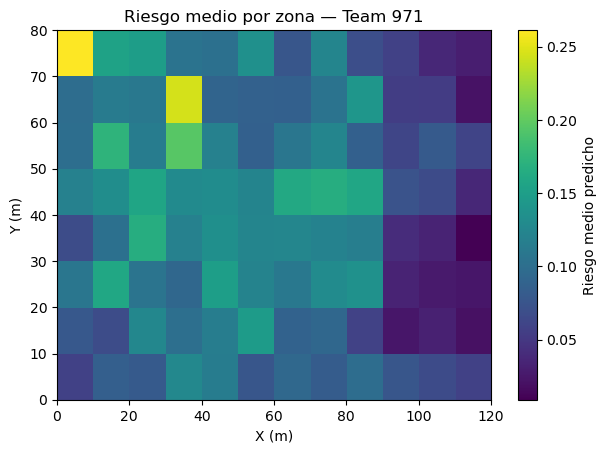

   zone_id   p_model    n      freq
7      0_7  0.261363   39  0.003977
46     3_6  0.244659   92  0.009381
45     3_5  0.195642  101  0.010299
29     1_5  0.172894   32  0.003263
76     7_4  0.166581   86  0.008769
35     2_3  0.166401   33  0.003365
68     6_4  0.160855   90  0.009177
26     1_2  0.159135   39  0.003977
84     8_4  0.158270   85  0.008667
36     2_4  0.157442   35  0.003569
31     1_7  0.154424   48  0.004894
50     4_2  0.150389   99  0.010095
39     2_7  0.149435   78  0.007954
57     5_1  0.147769  130  0.013256
86     8_6  0.141407  160  0.016315


In [ ]:
def plot_team_heatmap(model, data, team_id, title=None, outfile_png=None,
                      xbins=12, ybins=8, value_col="p_model", filter_expr=None):
    zt = team_zone_risk(model, data, team_id, filter_expr)


    grid = zone_table_to_grid(zt, xbins, ybins, value_col=value_col)

    plt.figure(figsize=(7,4.8))
    im = plt.imshow(grid, origin="lower", extent=[0,120,0,80], aspect="auto")
    plt.colorbar(im, label=("Riesgo medio predicho" if value_col=="p_model" else value_col))
    plt.title(title or f"Equipo {team_id} — {value_col}")
    plt.xlabel("X (m)"); plt.ylabel("Y (m)")

    if outfile_png:
        plt.savefig(outfile_png, bbox_inches="tight", dpi=150)
        print("Guardado:", outfile_png)
    plt.show()
    return zt

team_example = int(df["team_id"].mode().iloc[0]) 
zt = plot_team_heatmap(
    clf, df, team_example,
    title=f"Riesgo medio por zona — Team {team_example}",
    outfile_png=f"risk_map_team_{team_example}.png"
)
zt.to_csv(f"risk_ranking_team_{team_example}.csv", index=False)
print(zt.head(15))


### Cálculo de riesgo esperado por zona
Usamos las probabilidades y frecuencias por zonas para obtener el riesgo esperado por zona

In [ ]:

def team_expected_risk(model, data, team_id, min_n=40, filter_expr=None):
    zt = team_zone_risk(model, data, team_id, filter_expr)   
    if zt.empty: return zt
    zt = zt[zt["n"] >= min_n]     
    zt["expected_risk"] = zt["p_model"] * zt["freq"]
    return zt.sort_values("expected_risk", ascending=False)

team_example = 971 
tz_er = team_expected_risk(clf, df, team_example, min_n=40)
print(tz_er.head(12))  
tz_er.to_csv(f"expected_risk_team_{team_example}.csv", index=False)


   zone_id   p_model    n      freq  expected_risk
79     7_7  0.123488  205  0.020903       0.002581
86     8_6  0.141407  160  0.016315       0.002307
46     3_6  0.244659   92  0.009381       0.002295
63     5_7  0.135342  155  0.015805       0.002139
45     3_5  0.195642  101  0.010299       0.002015
57     5_1  0.147769  130  0.013256       0.001959
64     6_0  0.094614  202  0.020598       0.001949
80     8_0  0.099241  180  0.018354       0.001821
82     8_2  0.136402  124  0.012644       0.001725
77     7_5  0.124363  134  0.013664       0.001699
48     4_0  0.115178  142  0.014479       0.001668
72     7_0  0.082309  191  0.019476       0.001603


### Heatmap de diferencias entre condiciones


Guardado: delta_under_pressure_team_971.png


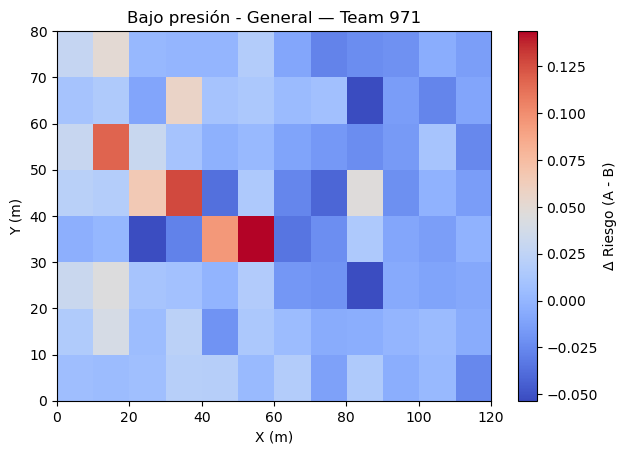

array([[ 0.0064419 ,  0.00442852,  0.00713764,  0.02038241,  0.01943758,
         0.00289168,  0.01762123, -0.01255319,  0.01528314, -0.00453975,
         0.00225319, -0.02513976],
       [ 0.01634775,  0.03911129,  0.00556769,  0.02242782, -0.01978909,
         0.01413982,  0.00481811, -0.00595274, -0.00480191,  0.00016242,
         0.00405084, -0.00612089],
       [ 0.0316434 ,  0.04490087,  0.01066867,  0.0085735 , -0.00097479,
         0.01726611, -0.01782584, -0.01982897, -0.0519213 , -0.00683975,
        -0.01071269, -0.00870654],
       [-0.00351486,  0.00066785, -0.05249348, -0.02816423,  0.09498645,
         0.14378283, -0.0345214 , -0.02225382,  0.0148728 , -0.00891098,
        -0.01387493, -0.00192684],
       [ 0.02184221,  0.01851486,  0.06583936,  0.12699361, -0.03655206,
         0.0150836 , -0.02636532, -0.04159886,  0.04647285, -0.0212885 ,
        -0.00253515, -0.01422688],
       [ 0.03010854,  0.11717821,  0.03103283,  0.00995291, -0.00304429,
         0.00258295, -

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def delta_heatmap(model, data, team_id, filter_expr_a, filter_expr_b,
                  title="Delta (A - B)", out_png=None, xbins=12, ybins=8):
    zA = team_zone_risk(model, data, team_id, filter_expr_a)
    zB = team_zone_risk(model, data, team_id, filter_expr_b)
    if zA.empty or zB.empty:
        print("Faltan datos para alguna condición")
        return None
    gA = zone_table_to_grid(zA, xbins, ybins, value_col="p_model")
    gB = zone_table_to_grid(zB, xbins, ybins, value_col="p_model")
    d  = gA - gB

    plt.figure(figsize=(7,4.8))
    im = plt.imshow(d, origin="lower", extent=[0,120,0,80], aspect="auto", cmap="coolwarm")
    plt.colorbar(im, label="Δ Riesgo (A - B)")
    plt.title(title + f" — Team {team_id}")
    plt.xlabel("X (m)"); plt.ylabel("Y (m)")
    if out_png:
        plt.savefig(out_png, bbox_inches="tight", dpi=150)
        print("Guardado:", out_png)
    plt.show()
    return d

# Ejemplo: Bajo presión vs General
delta_heatmap(
    clf, df, team_example,
    filter_expr_a="under_pressure == 1",
    filter_expr_b=None,
    title="Bajo presión - General",
    out_png=f"delta_under_pressure_team_{team_example}.png"
)


###  Visualización de todos los heatmaps por team




Guardado: risk_map_team_746.png


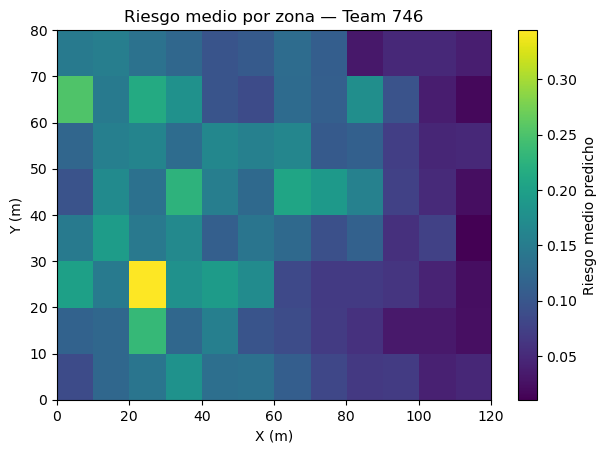

Guardado: risk_map_team_749.png


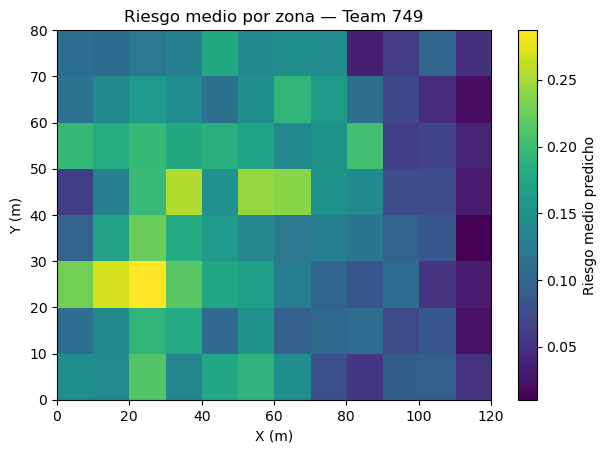

Guardado: risk_map_team_965.png


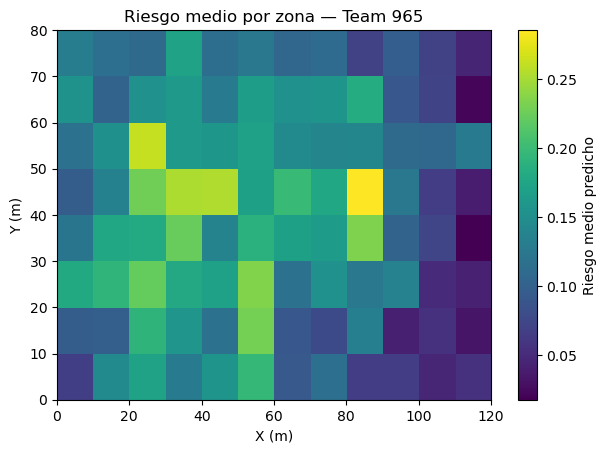

Guardado: risk_map_team_967.png


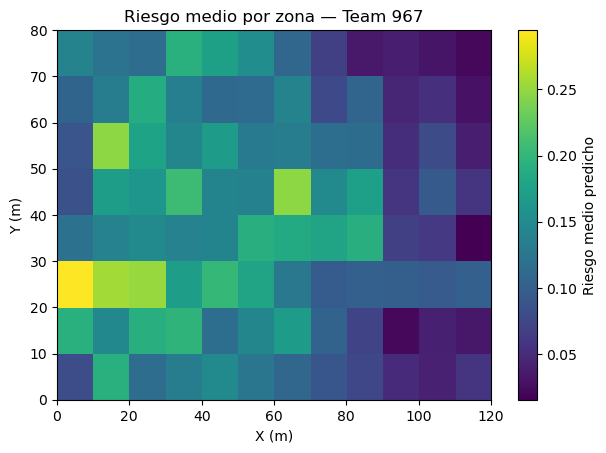

Guardado: risk_map_team_968.png


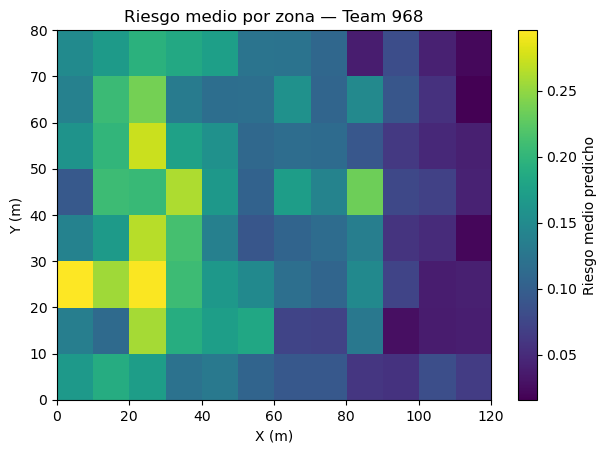

Guardado: risk_map_team_969.png


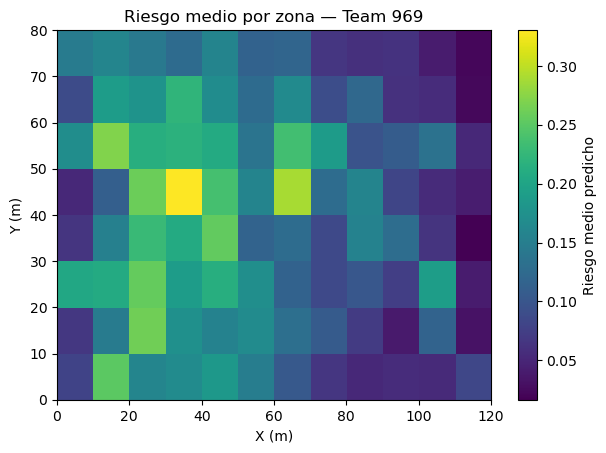

Guardado: risk_map_team_971.png


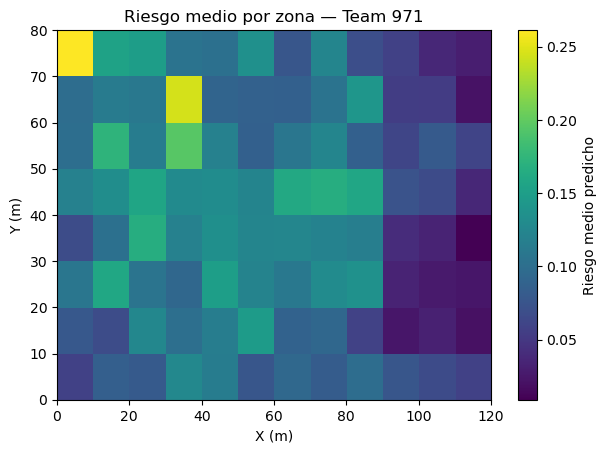

Guardado: risk_map_team_972.png


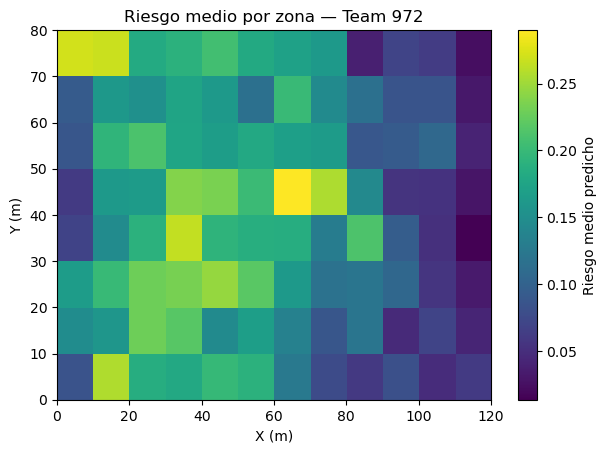

Guardado: risk_map_team_973.png


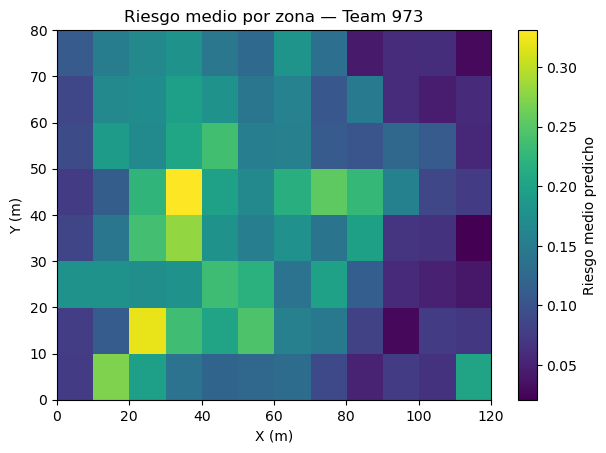

Guardado: risk_map_team_974.png


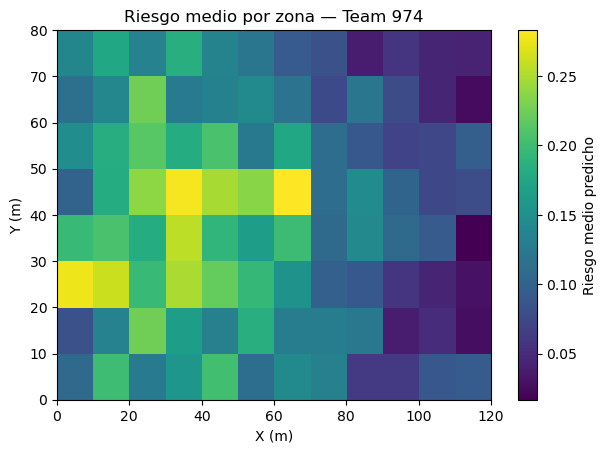

Guardado: risk_map_team_1475.png


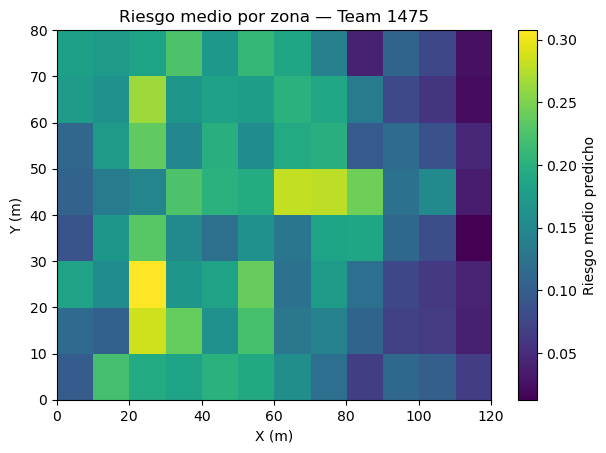

Guardado: risk_map_team_2647.png


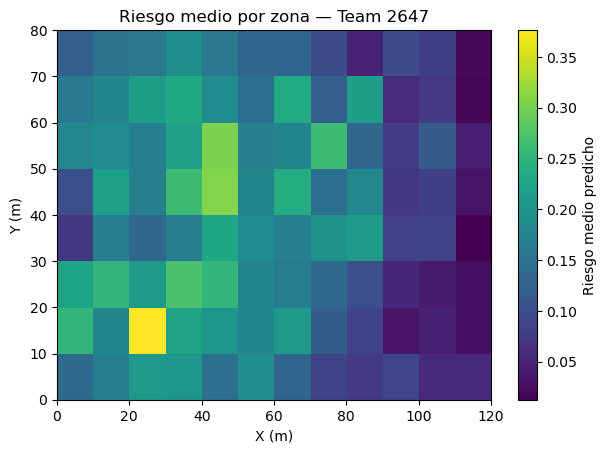

Guardado: risk_map_team_746_under_pressure.png


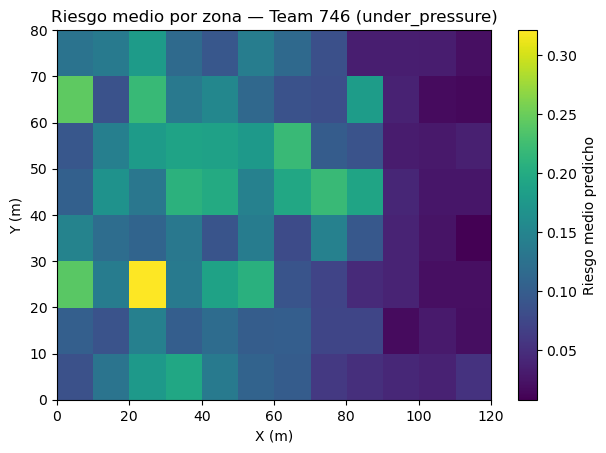

Guardado: risk_map_team_749_under_pressure.png


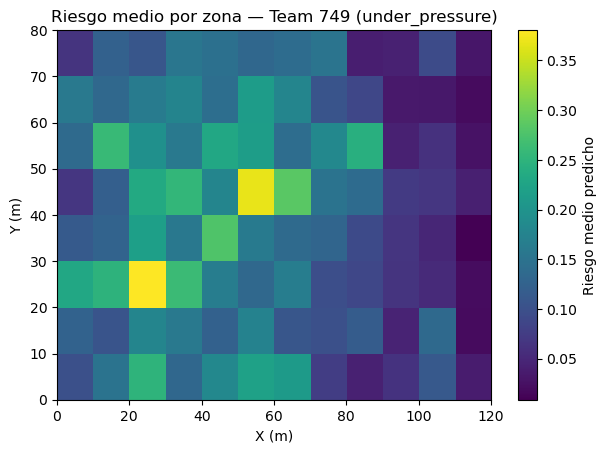

Guardado: risk_map_team_965_under_pressure.png


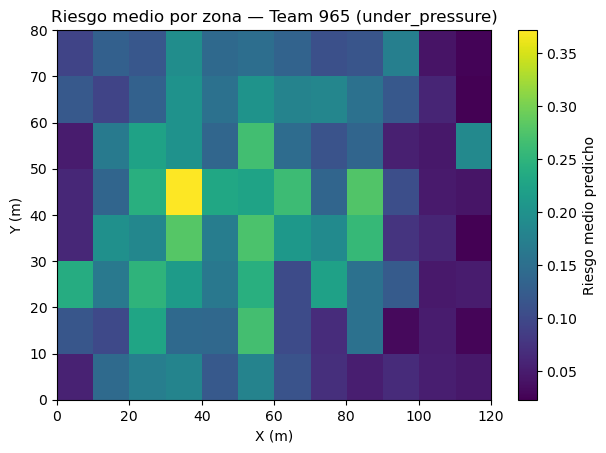

Guardado: risk_map_team_967_under_pressure.png


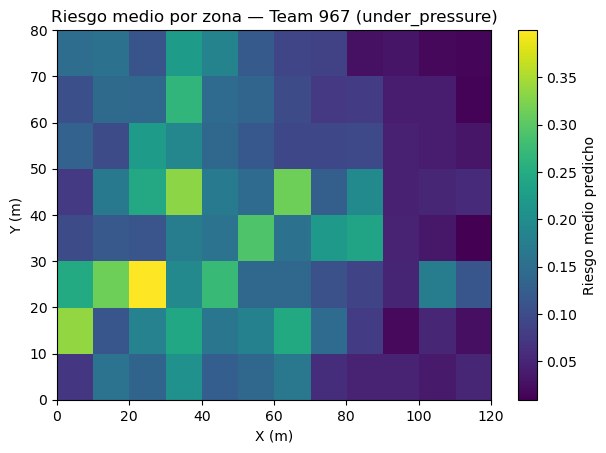

Guardado: risk_map_team_968_under_pressure.png


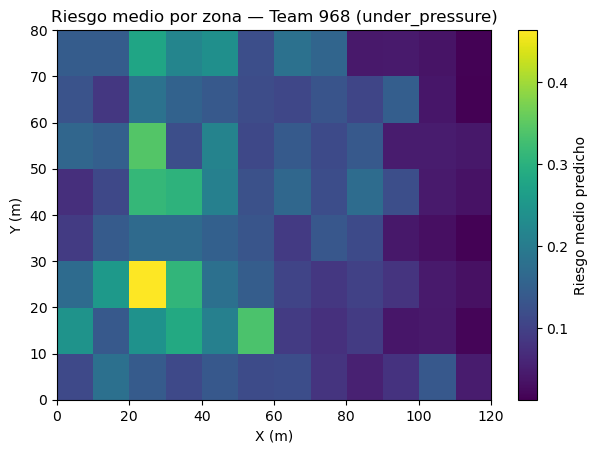

Guardado: risk_map_team_969_under_pressure.png


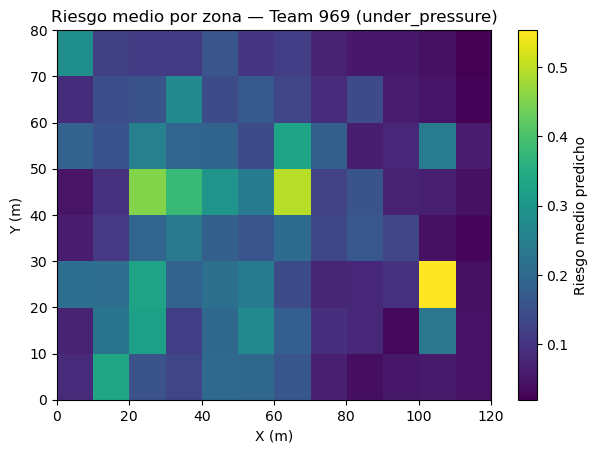

Guardado: risk_map_team_971_under_pressure.png


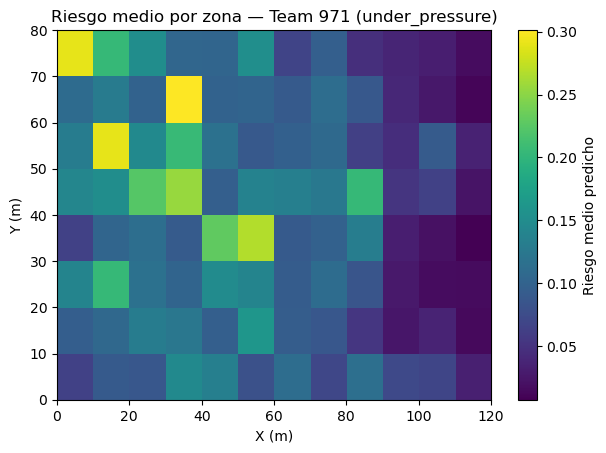

Guardado: risk_map_team_972_under_pressure.png


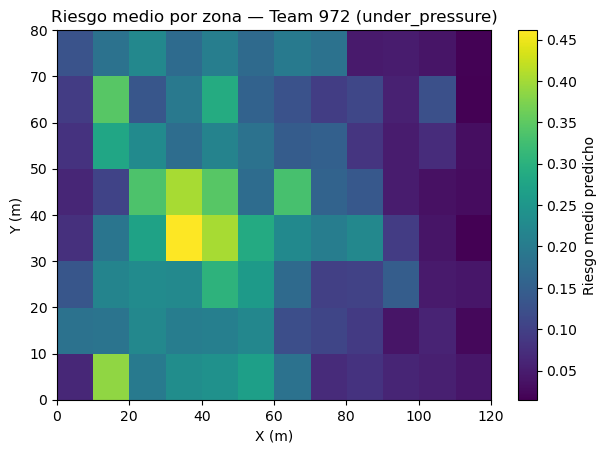

Guardado: risk_map_team_973_under_pressure.png


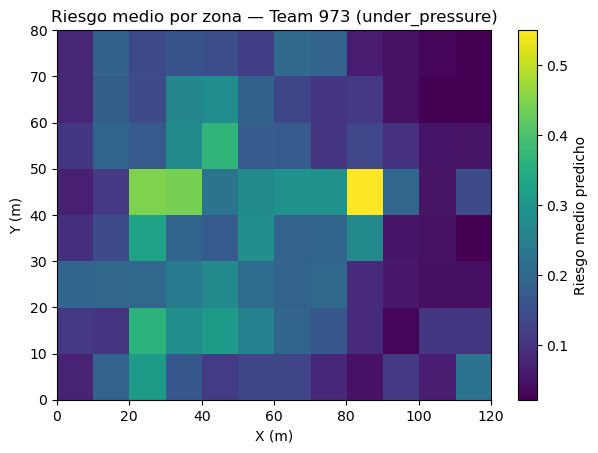

Guardado: risk_map_team_974_under_pressure.png


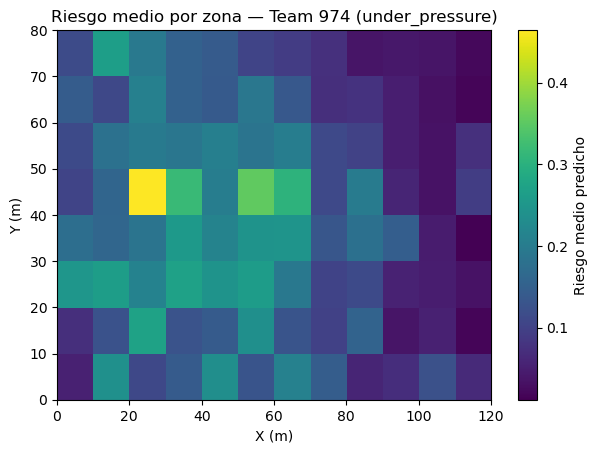

Guardado: risk_map_team_1475_under_pressure.png


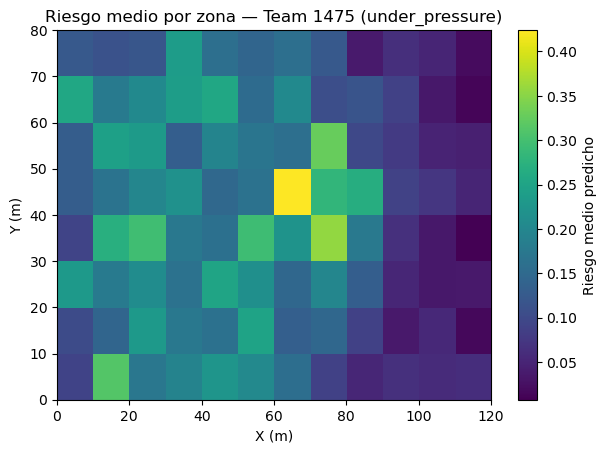

Guardado: risk_map_team_2647_under_pressure.png


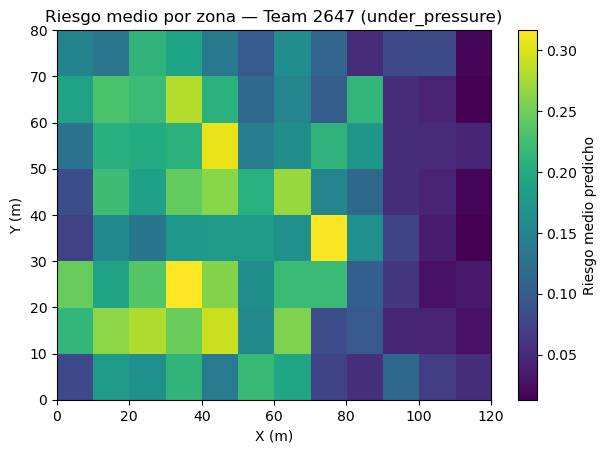

In [ ]:
all_teams = sorted(df["team_id"].dropna().unique().astype(int).tolist())

def export_maps_for_all(model, data, teams, suffix="", filter_expr=None):
    for tid in teams:
        try:
            title = f"Riesgo medio por zona — Team {tid}{' ('+suffix+')' if suffix else ''}"
            png = f"risk_map_team_{tid}{('_'+suffix) if suffix else ''}.png"
            zt  = plot_team_heatmap(model, data, tid, title=title, outfile_png=png,
                                    value_col="p_model", filter_expr=filter_expr)
            if not zt.empty:
                zt.to_csv(f"risk_ranking_team_{tid}{('_'+suffix) if suffix else ''}.csv", index=False)
        except Exception as e:
            print(f"Team {tid} falló: {e}")

export_maps_for_all(clf, df, all_teams)

export_maps_for_all(clf, df, all_teams, suffix="under_pressure", filter_expr="under_pressure == 1")


### Centros de zona y checklist táctico

In [18]:
def zone_centers(xbins=12, ybins=8):
    x_edges = np.linspace(0,120,xbins+1)
    y_edges = np.linspace(0, 80,ybins+1)
    xc = (x_edges[:-1]+x_edges[1:])/2
    yc = (y_edges[:-1]+y_edges[1:])/2
    centers = {}
    for zx in range(xbins):
        for zy in range(ybins):
            centers[f"{zx}_{zy}"] = (float(xc[zx]), float(yc[zy]))
    return centers

centers = zone_centers()

def coaching_checklist(zone_table, top=8):
    tips = []
    z = zone_table.head(top)
    for _, r in z.iterrows():
        zx, zy = map(int, r["zone_id"].split("_"))
        xc, yc = centers[r["zone_id"]]
        flank = "banda" if zx in [0,1,10,11] else "interior"
        half  = "propio" if zx <= 5 else "rival"
        tips.append({
            "zone_id": r["zone_id"],
            "centro_x": round(xc,1), "centro_y": round(yc,1),
            "riesgo": round(r["p_model"],3),
            "freq": round(r["freq"],3),
            "sugerencia": (
                f"En {half}-{flank}: priorizar salida segura (apoyo cercano), "
                f"evitar controles orientados al centro si hay presión; "
                f"si {flank=='banda'}: usar línea y tercer hombre."
            )
        })
    return pd.DataFrame(tips)

chk = coaching_checklist(tz_er, top=8)
print(chk)
chk.to_csv(f"checklist_team_{team_example}.csv", index=False)


  zone_id  centro_x  centro_y  riesgo   freq  \
0     7_7      75.0      75.0   0.123  0.021   
1     8_6      85.0      65.0   0.141  0.016   
2     3_6      35.0      65.0   0.245  0.009   
3     5_7      55.0      75.0   0.135  0.016   
4     3_5      35.0      55.0   0.196  0.010   
5     5_1      55.0      15.0   0.148  0.013   
6     6_0      65.0       5.0   0.095  0.021   
7     8_0      85.0       5.0   0.099  0.018   

                                          sugerencia  
0  En rival-interior: priorizar salida segura (ap...  
1  En rival-interior: priorizar salida segura (ap...  
2  En propio-interior: priorizar salida segura (a...  
3  En propio-interior: priorizar salida segura (a...  
4  En propio-interior: priorizar salida segura (a...  
5  En propio-interior: priorizar salida segura (a...  
6  En rival-interior: priorizar salida segura (ap...  
7  En rival-interior: priorizar salida segura (ap...  


## Obtenemos los nombres reales de los equipos para no poner números

In [ ]:

events = pd.read_csv("events_all_wsl2021.csv", usecols=["team_id","team"], low_memory=False)
events = events.dropna(subset=["team_id","team"])
events["team_id"] = pd.to_numeric(events["team_id"], errors="coerce").astype("Int64")
events["team"] = events["team"].astype(str).str.strip()

id2name = (events.groupby("team_id")["team"]
                 .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
                 .astype(str)
                 .to_dict())
name2id = {v.lower(): int(k) for k, v in id2name.items()}

def team_label(team_id):
    """Texto bonito para títulos/archivos."""
    try:
        return id2name.get(int(team_id), f"Team {int(team_id)}")
    except:
        return f"Team {team_id}"

def slug(s):
    """Nombre de archivo seguro."""
    return re.sub(r"[^A-Za-z0-9]+", "_", str(s)).strip("_").lower()


## Mapas con los nombres de los equipos

Guardado: risk_map_west_ham_united_lfc.png


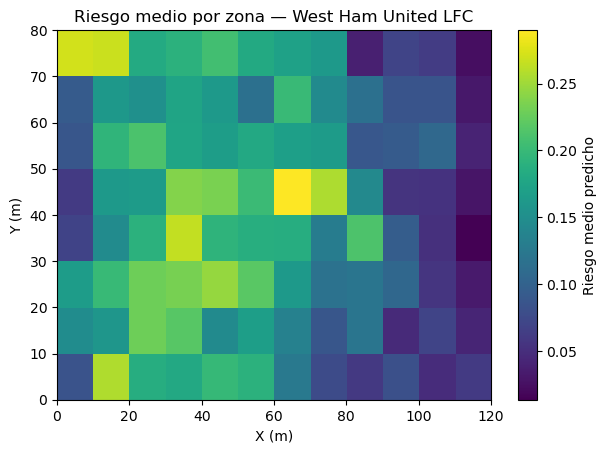

   zone_id   p_model    n      freq            team_name
68     6_4  0.289958   98  0.010653  West Ham United LFC
7      0_7  0.270804   27  0.002935  West Ham United LFC
31     1_7  0.267802   32  0.003479  West Ham United LFC
43     3_3  0.265103   69  0.007501  West Ham United LFC
24     1_0  0.257264   86  0.009349  West Ham United LFC
76     7_4  0.256272   58  0.006305  West Ham United LFC
50     4_2  0.246352  124  0.013480  West Ham United LFC
44     3_4  0.239041   52  0.005653  West Ham United LFC
52     4_4  0.234380   77  0.008370  West Ham United LFC
42     3_2  0.233221   62  0.006740  West Ham United LFC
33     2_1  0.228958   90  0.009784  West Ham United LFC
34     2_2  0.228476   87  0.009458  West Ham United LFC


In [ ]:

team_example = name2id["west ham united lfc".lower()]  

zt = plot_team_heatmap(
    clf, df, team_example,
    title=f"Riesgo medio por zona — {team_label(team_example)}",
    outfile_png=f"risk_map_{slug(team_label(team_example))}.png"
)
zt["team_name"] = team_label(team_example)
zt.to_csv(f"risk_ranking_{slug(team_label(team_example))}.csv", index=False)
print(zt.head(12))


### Imprimimos mapas de todos los equipos

Guardado: risk_map_manchester_city_wfc.png


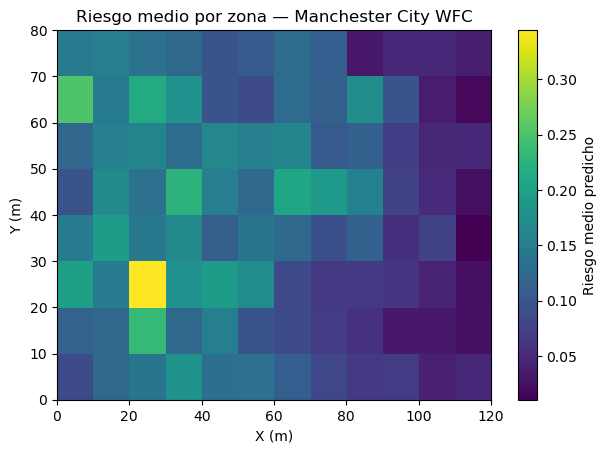

Guardado: risk_map_tottenham_hotspur_women.png


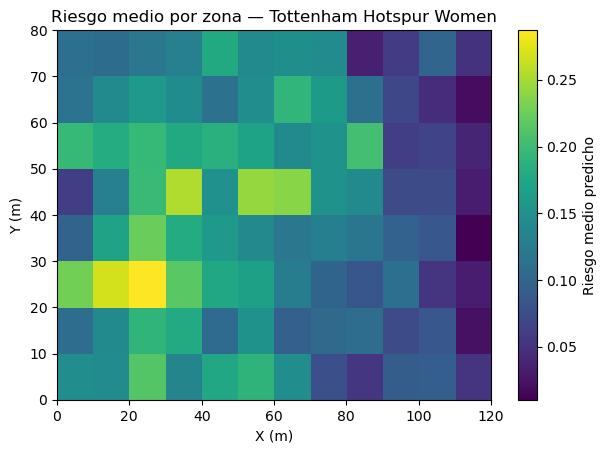

Guardado: risk_map_brighton_hove_albion_wfc.png


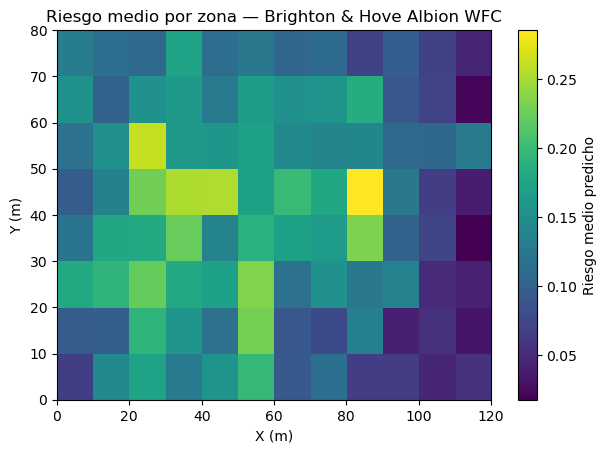

Guardado: risk_map_everton_lfc.png


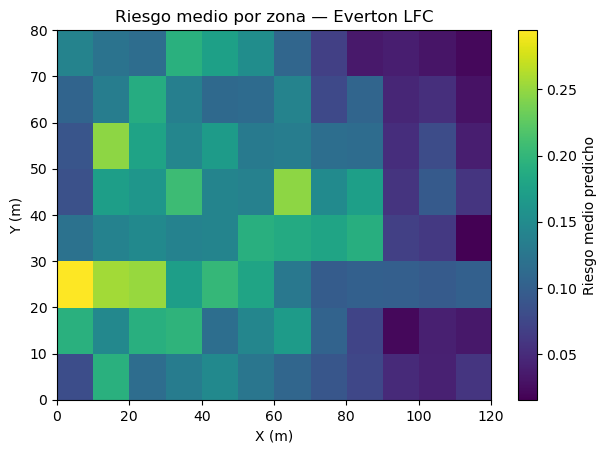

Guardado: risk_map_arsenal_wfc.png


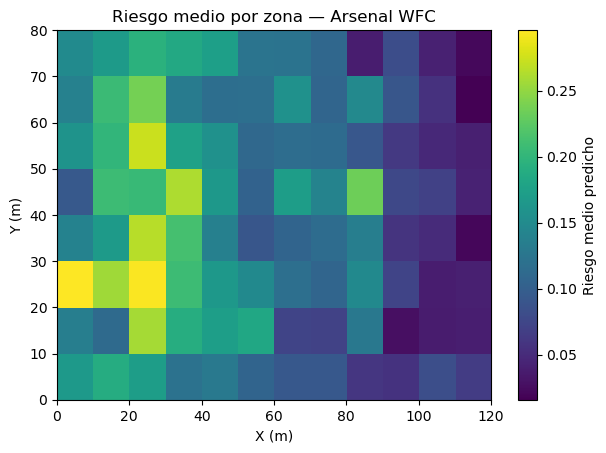

Guardado: risk_map_birmingham_city_wfc.png


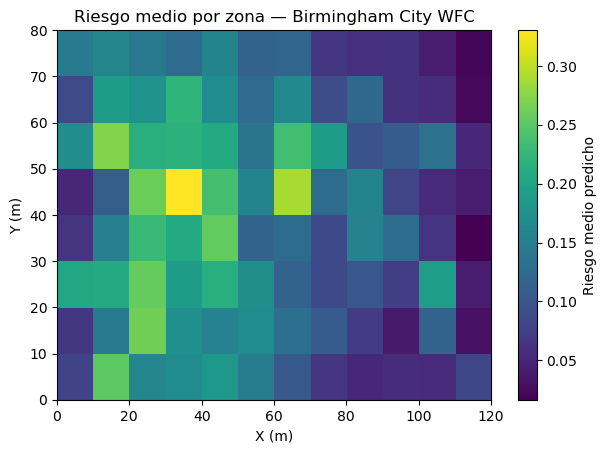

Guardado: risk_map_chelsea_fcw.png


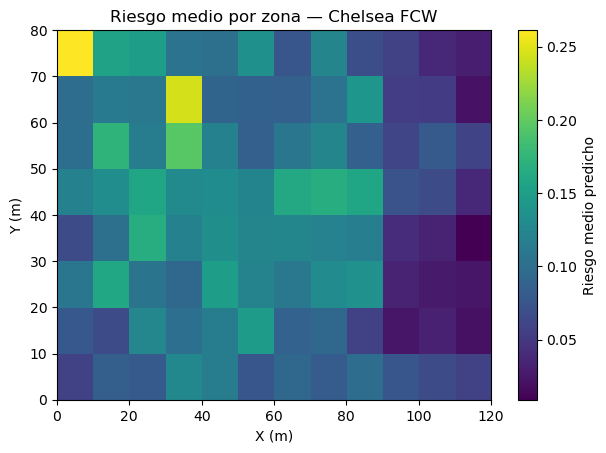

Guardado: risk_map_west_ham_united_lfc.png


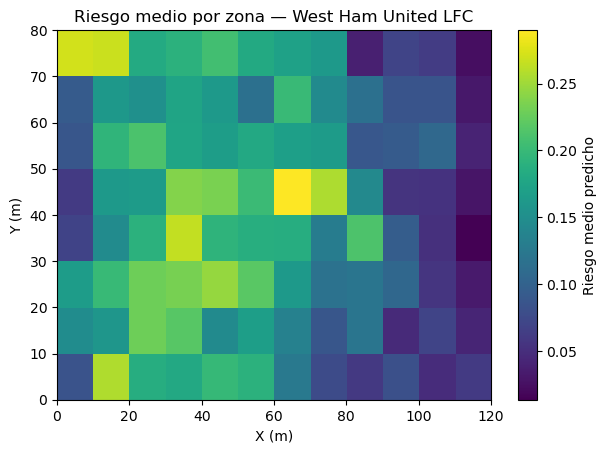

Guardado: risk_map_bristol_city_wfc.png


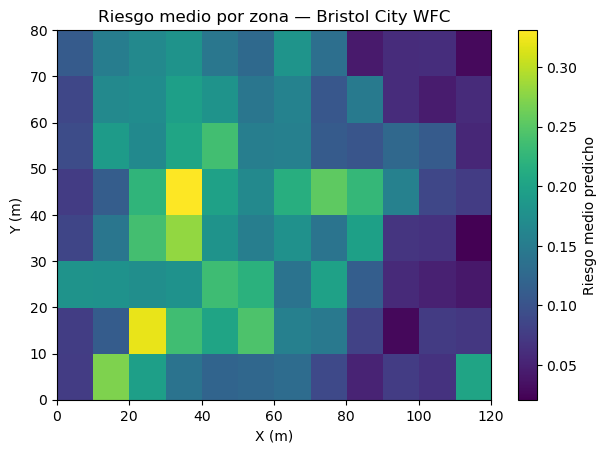

Guardado: risk_map_reading_wfc.png


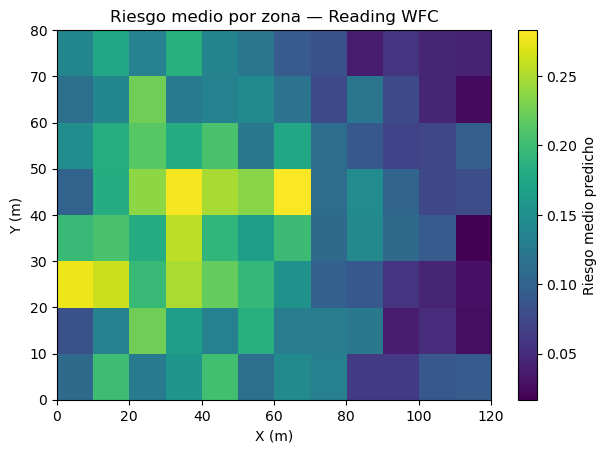

Guardado: risk_map_manchester_united.png


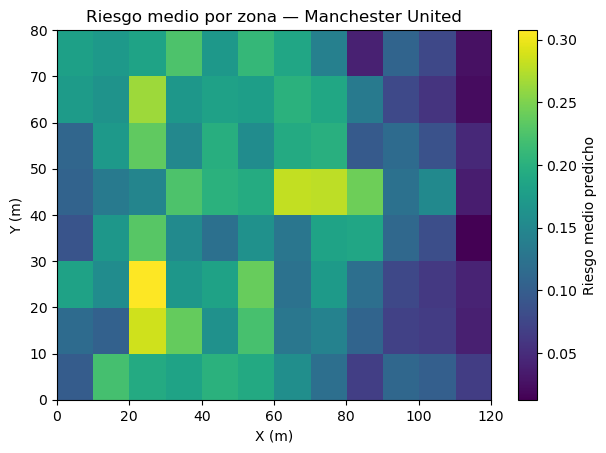

Guardado: risk_map_aston_villa.png


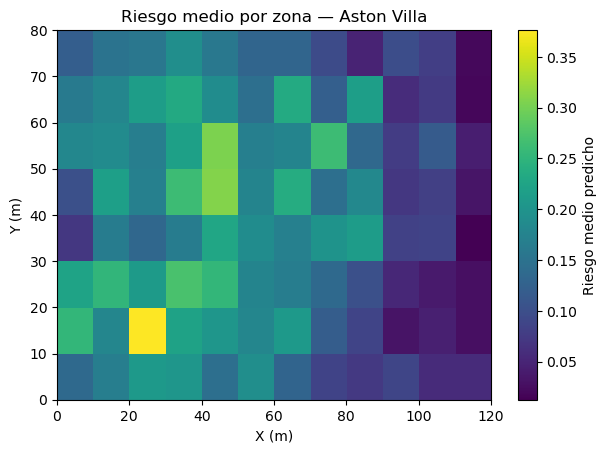

Guardado: risk_map_manchester_city_wfc_under_pressure.png


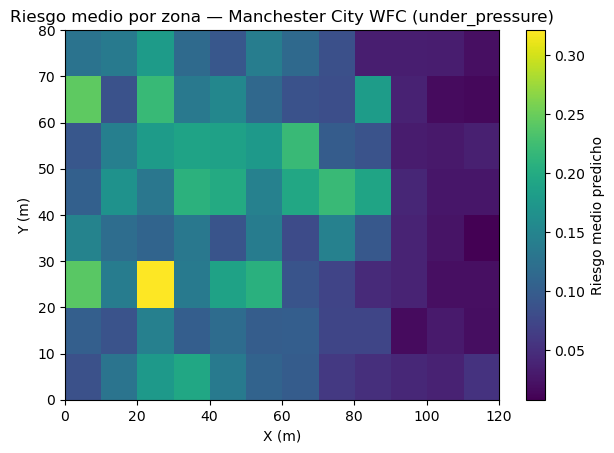

Guardado: risk_map_tottenham_hotspur_women_under_pressure.png


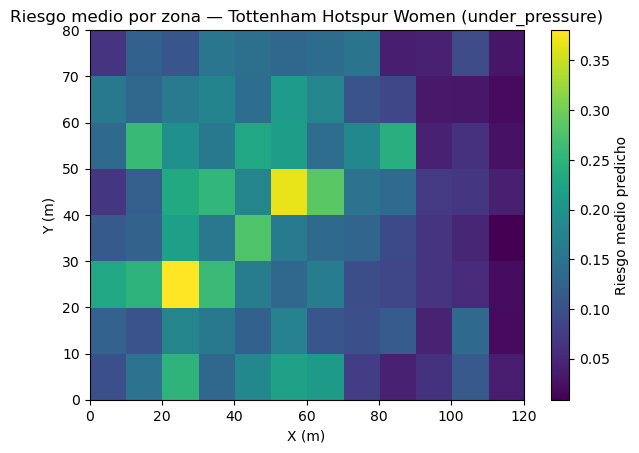

Guardado: risk_map_brighton_hove_albion_wfc_under_pressure.png


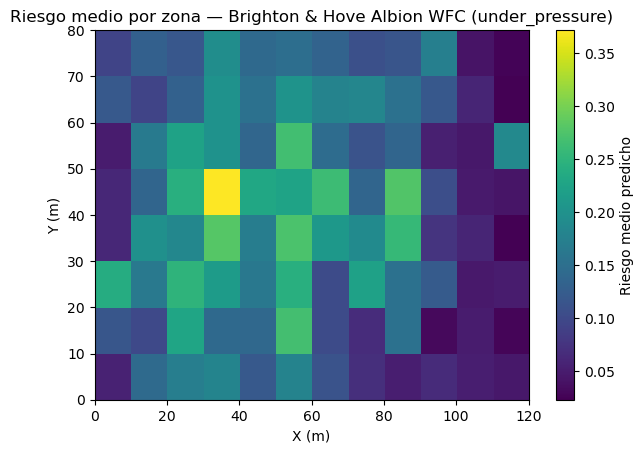

Guardado: risk_map_everton_lfc_under_pressure.png


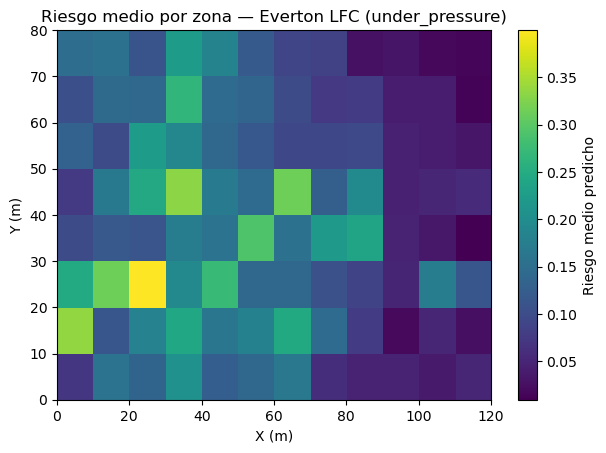

Guardado: risk_map_arsenal_wfc_under_pressure.png


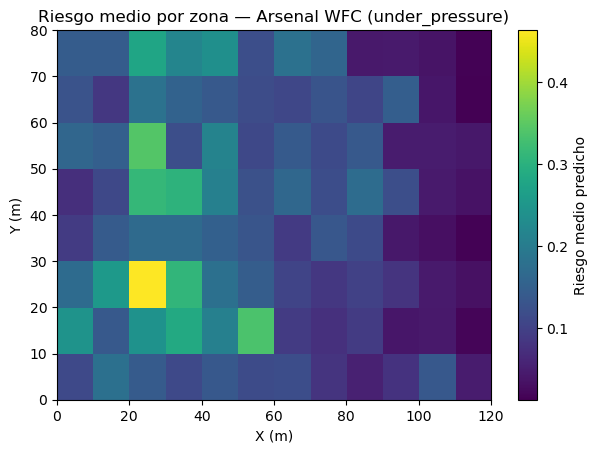

Guardado: risk_map_birmingham_city_wfc_under_pressure.png


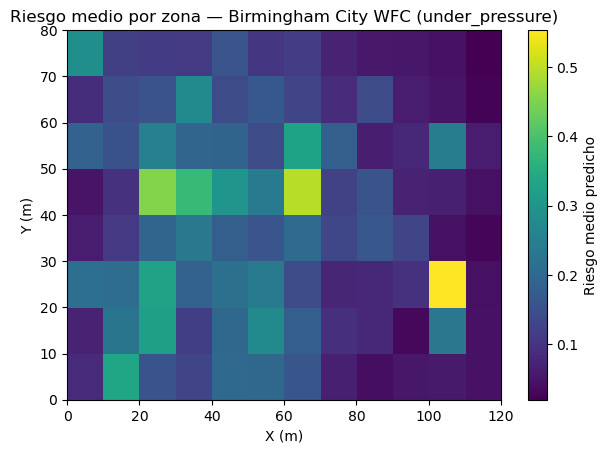

Guardado: risk_map_chelsea_fcw_under_pressure.png


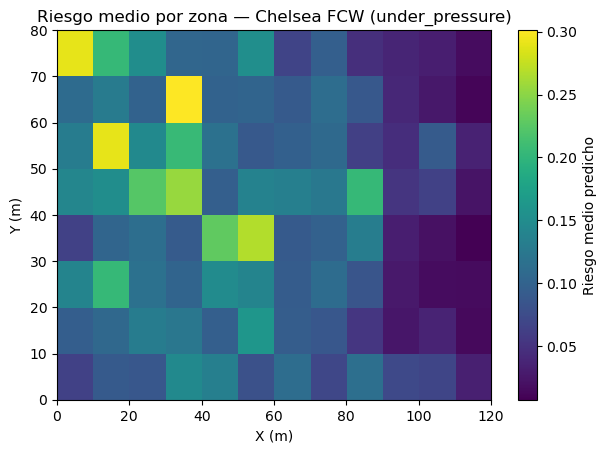

Guardado: risk_map_west_ham_united_lfc_under_pressure.png


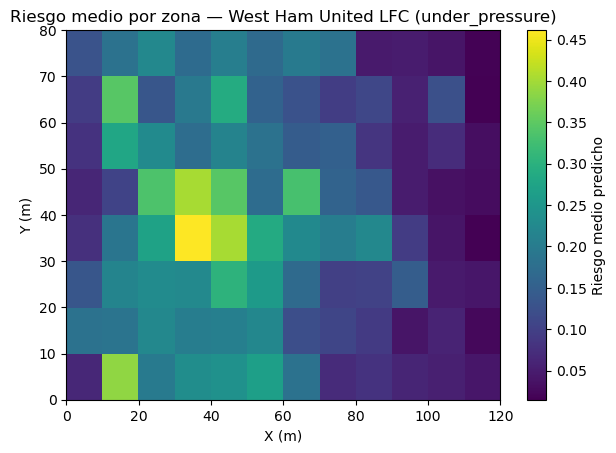

Guardado: risk_map_bristol_city_wfc_under_pressure.png


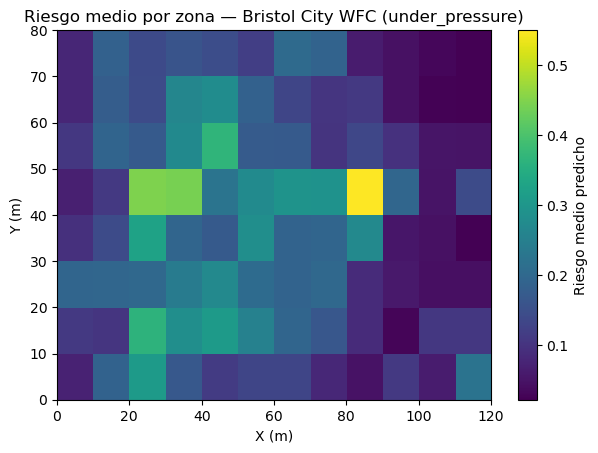

Guardado: risk_map_reading_wfc_under_pressure.png


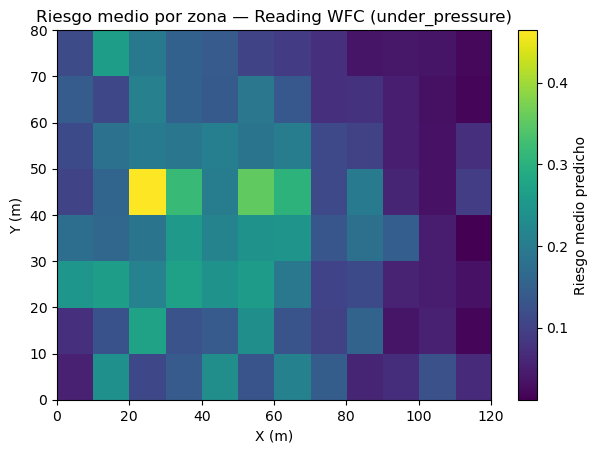

Guardado: risk_map_manchester_united_under_pressure.png


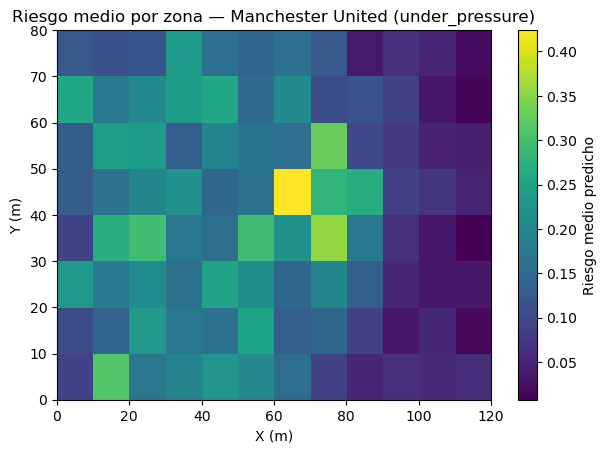

Guardado: risk_map_aston_villa_under_pressure.png


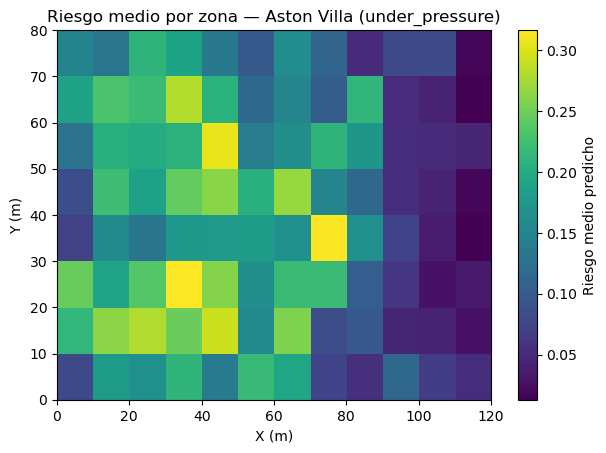

In [21]:
all_team_ids = sorted(df["team_id"].dropna().astype(int).unique().tolist())

def export_maps_for_all(model, data, team_ids, suffix="", filter_expr=None):
    for tid in team_ids:
        try:
            name = team_label(tid)
            title = f"Riesgo medio por zona — {name}" + (f" ({suffix})" if suffix else "")
            png   = f"risk_map_{slug(name)}" + (f"_{suffix}" if suffix else "") + ".png"
            zt = plot_team_heatmap(model, data, tid, title=title, outfile_png=png,
                                   value_col="p_model", filter_expr=filter_expr)
            if not zt.empty:
                zt["team_id"] = tid
                zt["team_name"] = name
                zt.to_csv(f"risk_ranking_{slug(name)}" + (f"_{suffix}" if suffix else "") + ".csv",
                          index=False)
        except Exception as e:
            print(f"Team {tid} ({team_label(tid)}) falló: {e}")

# General
export_maps_for_all(clf, df, all_team_ids)

# Bajo presión (ejemplo)
export_maps_for_all(clf, df, all_team_ids, suffix="under_pressure", filter_expr="under_pressure == 1")
